Note: This notebook replicates the final pipeline (MLPClassifier) with the selected hyperparameters and performs the full evaluation.
`Rolling_test` validation to simulate historical performance.
Decision threshold optimization (`optimize_threshold`) to fine-tune sensitivity and accuracy.
Evaluation on a subsequent real holdout set.
The pipeline is the same as the modeling notebook, except:
`GridSearchCV` is not used.
The evaluation is based directly on `Rolling_test`, which is more realistic for time series.

In [180]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, precision_score, recall_score, brier_score_loss
from model_utils import rolling_test, optimize_threshold
from preprocessing import feature_engineering, analyze_features
from datetime import datetime
import joblib
import warnings
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [181]:
df = pd.read_csv('../data/df.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('../data/btc_test.csv', index_col='date', parse_dates=True)

df_full = pd.concat([df, df_test])
df_full = df_full.sort_index()

df_full["target"] = (df_full["close"].shift(-1) > df_full["close"]).astype(int)

In [182]:
features_df = feature_engineering(df_full)
features_df["target"] = df_full["target"]
features_df.dropna(inplace=True)

In [183]:
X = features_df.loc[:'2025-05-28'].drop(columns='target')
y = features_df.loc[:'2025-05-28']['target']

In [184]:
X_real_test = features_df.loc["2025-05-29":"2025-07-13"].drop(columns="target")
y_real_test = features_df.loc["2025-05-29":"2025-07-13"]["target"]

In [185]:
pipeline = Pipeline([
    ('power', PowerTransformer('yeo-johnson')),
    ('scaler', QuantileTransformer(output_distribution='normal', random_state=42)),
    ('model', MLPClassifier(
        random_state=42,
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        alpha=0.005,
        learning_rate_init=0.0005,
        early_stopping=True,
        n_iter_no_change=20,
        batch_size=16
    ))
])

In [186]:
results = rolling_test(pipeline, X, y, test_window=50, step=25, min_train_size=250, verbose=True)

>>> Rolling Test (threshold 0.5):
Mean Accuracy: 0.5475
Mean F1 Score: 0.6128
Mean ROC AUC Score: 0.6006


To improve the model's predictive performance, particularly on imbalanced or noisy data, we applied a custom threshold selection strategy based on F1 score optimization using predicted probabilities from the rolling test.

   - Optimal threshold was found at 0.36, instead of the default 0.5, as shown in the plot. This value maximized the F1 score and led to a more balanced trade-off between precision and recall.

   - The F1 score remained relatively stable across a wide range of low thresholds, but dropped significantly beyond 0.5, indicating that using higher cutoffs would have biased the model heavily toward the negative class.

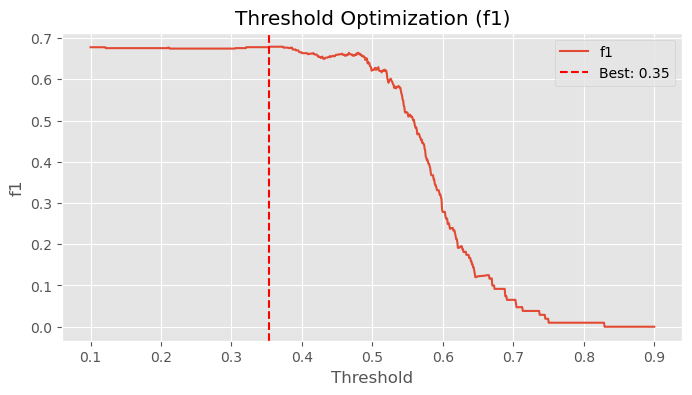

Best threshold: 0.3530530530530531, Best Metric Score: 0.6789297658862876


In [187]:
y_true_all = results["y_true"]
y_proba_all = results["y_proba"]

best_thresh, best_score = optimize_threshold(y_true_all, y_proba_all, metric='f1')
print(f"Best threshold: {best_thresh}, Best Metric Score: {best_score}")
# We have a gap between 0.35 and 0.48 threshold, for more flexibility, as the threshold converges
# f1 equally for 0.35 and 0.48, we choose 0.48.
best_thresh = 0.47

In [188]:
y_pred_adjusted = (y_proba_all >= best_thresh).astype(int)
acc_adj = accuracy_score(y_true_all, y_pred_adjusted)
f1_adj = f1_score(y_true_all, y_pred_adjusted)
roc_adj = roc_auc_score(y_true_all, y_proba_all)
print(f"Adjusted Accuracy: {acc_adj}, \nAdjusted F1 Score: {f1_adj}, \nAdjusted ROC AUC: {roc_adj}")

Adjusted Accuracy: 0.545, 
Adjusted F1 Score: 0.6604477611940298, 
Adjusted ROC AUC: 0.5873671044402752


In [189]:
power = pipeline.named_steps['power']
scaler = pipeline.named_steps['scaler']
base_model = pipeline.named_steps['model']
cloned_model = clone(base_model)

We are also calibrating the model with Platt Scaling (`sigmoid`) which is better for small samples. Using cross validation folds for calibrating in this case is better because we can take advantage of the avaiable data, instead of using a prefit which means that we need to re-split manually the set, or use part of the hold out.

In [190]:
calibrated = CalibratedClassifierCV(
    base_estimator=cloned_model,
    method='sigmoid',
    cv=3
)

In [191]:
calibrated_pipeline = Pipeline([
    ('power', power),
    ('scaler', scaler),
    ('model', calibrated)
])

In [192]:
calibrated_pipeline.fit(X, y)

y_real_proba = calibrated_pipeline.predict_proba(X_real_test)[:, 1]
y_real_pred = (y_real_proba >= best_thresh).astype(int)

In [193]:
accuracy = accuracy_score(y_real_test, y_real_pred)
f1 = f1_score(y_real_test, y_real_pred)
roc = roc_auc_score(y_real_test, y_real_proba)
brier = brier_score_loss(y_real_test, y_real_proba)

print("Hold-out Set Evaluation (with Calibrated Probabilities):")
print(f"Threshold: {best_thresh:.2f}")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc)
print("Brier Score:", brier)

Hold-out Set Evaluation (with Calibrated Probabilities):
Threshold: 0.47
Accuracy: 0.5869565217391305
F1 Score: 0.7397260273972603
ROC AUC Score: 0.4834307992202729
Brier Score: 0.24793750839898476


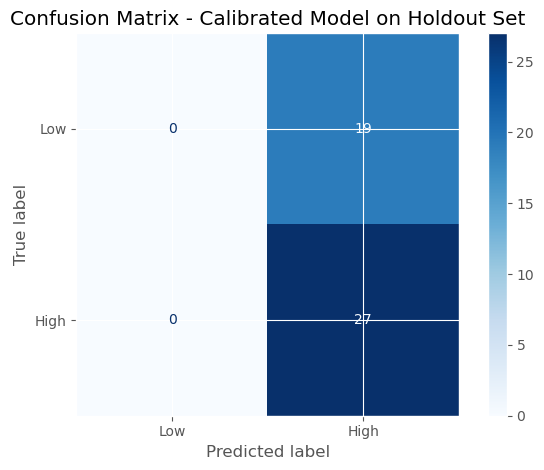

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_real_test, y_real_pred, display_labels=["Low", "High"], cmap="Blues")
plt.title("Confusion Matrix - Calibrated Model on Holdout Set")
plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix_holdout_set.png")
plt.show()
plt.close()

The confusion matrix indicates that the model tends to overpredict the positive class, which is consistent with the threshold adjustment. While this leads to a higher false positive rate, it also reduces false negatives, which is preferable in the context of directional trading signals where missing an opportunity (false negative) is often costlier than acting on a false alert.

The F1 score on the holdout set is consistent with the cross-validation result, confirming the generalization of the optimized threshold.
The low AUC suggests the model struggles to rank predictions effectively, which may be due to limited data, overlapping class distributions, or limited separability in the feature space. However, the F1 score remains high, showing the model still manages to predict directional movements effectively after calibration.

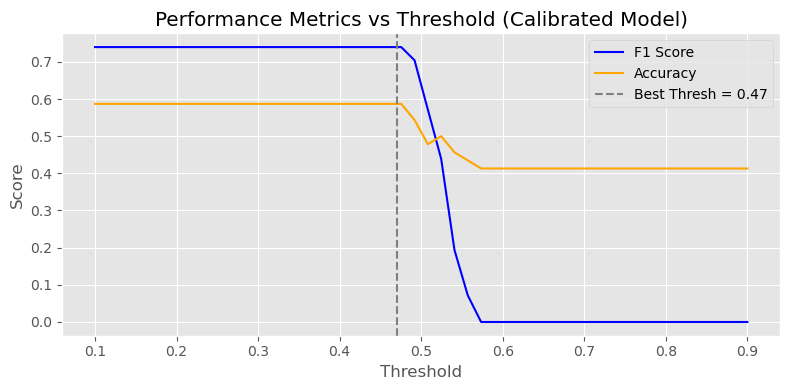

In [195]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_real_test, (y_real_proba >= t).astype(int)) for t in thresholds]
acc_scores = [accuracy_score(y_real_test, (y_real_proba >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label="F1 Score", color="blue")
plt.plot(thresholds, acc_scores, label="Accuracy", color="orange")
plt.axvline(best_thresh, linestyle="--", color="gray", label=f"Best Thresh = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Calibrated Model)")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/figures/metrics_vs_threshold_calibrated.png")
plt.show()
plt.close()


In the probability distribution plot, we observe a high degree of overlap between the predicted probabilities for both classes, consistent with the modest AUC scores. However, the chosen threshold effectively separates many of the true positives while minimizing false negatives.

   - As shown in the Performance vs Threshold plot, the optimized threshold improved F1 at the expense of some accuracy. This is expected and acceptable given the primary goal of maximizing classification quality for the positive class.

Based on the shape of the F1 curve, further fine-tuning the threshold won’t bring significant gains. Thresholds between 0.3 and 0.48 perform similarly, with a clear drop-off after 0.5. Unless new features, this threshold is likely close to optimal given the current setup.

In [196]:
joblib.dump(calibrated_pipeline, '../models/final_mlp_pipeline.joblib')

['../models/final_mlp_pipeline.joblib']

In [197]:
X_real_test.to_csv('../data/X_real_test.csv')
y_real_test.to_csv('../data/y_real_test.csv')

In [198]:
model_name = "MLPClassifier"
date = datetime.today().strftime('%Y-%m-%d')
threshold = best_thresh

results_df = pd.DataFrame([{
    "date": date,
    "model": model_name,
    "threshold": threshold,
    "accuracy": round(accuracy, 4),
    "f1_score": round(f1, 4),
    "roc_auc": round(roc, 4),
    "brier_score": round(brier, 4)
}])

results_path = "../reports/final_results.csv"
results_df.to_csv(results_path, index=False)

In [199]:
df_preds = pd.DataFrame({
    "prediction": y_real_pred,
    "actual": y_real_test.values
}, index=X_real_test.index)
df_preds.to_csv('../reports/df_preds.csv')

In [200]:
with open("../models/best_threshold.txt", "w") as f:
    f.write(str(best_thresh))

In [201]:
with open("../models/power_transformer.pkl", "wb") as f:
    joblib.dump(power, f)
with open("../models/scaler.pkl", "wb") as f:
    joblib.dump(scaler, f)

In [202]:
import json

feature_list = list(X.columns)
with open("../models/feature_list.json", "w") as f:
    json.dump(feature_list, f, indent=2)